<a href="https://colab.research.google.com/github/appleBattery/Image-Reconstruction-using-FBP/blob/main/Image_reconstruct_using_FBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and dependencies

In [1]:
# !pip install scikit-image
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from skimage import io # scikit image has important image processing tools
from skimage.util import img_as_ubyte, invert
from skimage.transform import rotate, rescale

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.signal import convolve
from skimage.color import rgb2gray
from skimage.transform import radon, iradon
from scipy.signal import convolve

# Cargar la imagen original
img = rgb2gray(plt.imread('d:/input/blurred1 - copia.png'))

# Tomar la transformada de Radon de la imagen
theta = np.linspace(0.0, 180.0, 180, endpoint=False)
theta.shape

(180,)

In [3]:
import time

start = time.time()
sinogram = radon(img, theta=theta, circle=False)
print(time.time()-start)

21.326122760772705


In [4]:
sinogram.shape

(2122, 180)

In [5]:
# Aplicar el filtro ramp en el espacio de la transformada de Radon
filter_kernel = np.abs(np.linspace(-1.0, 1.0, sinogram.shape[1])).reshape(1,-1)
filter_kernel.shape
# filter_kernel es 1 -> 0 -> 1

(1, 180)

In [6]:
filtered_sinogram = convolve(sinogram, filter_kernel)
filtered_sinogram.shape

(2122, 359)

In [7]:
start = time.time()
reconstruction=iradon(sinogram, theta=theta, filter_name='ramp')
print(time.time()-start)

10.586183309555054


In [8]:
reconstruction.shape

(2122, 2122)

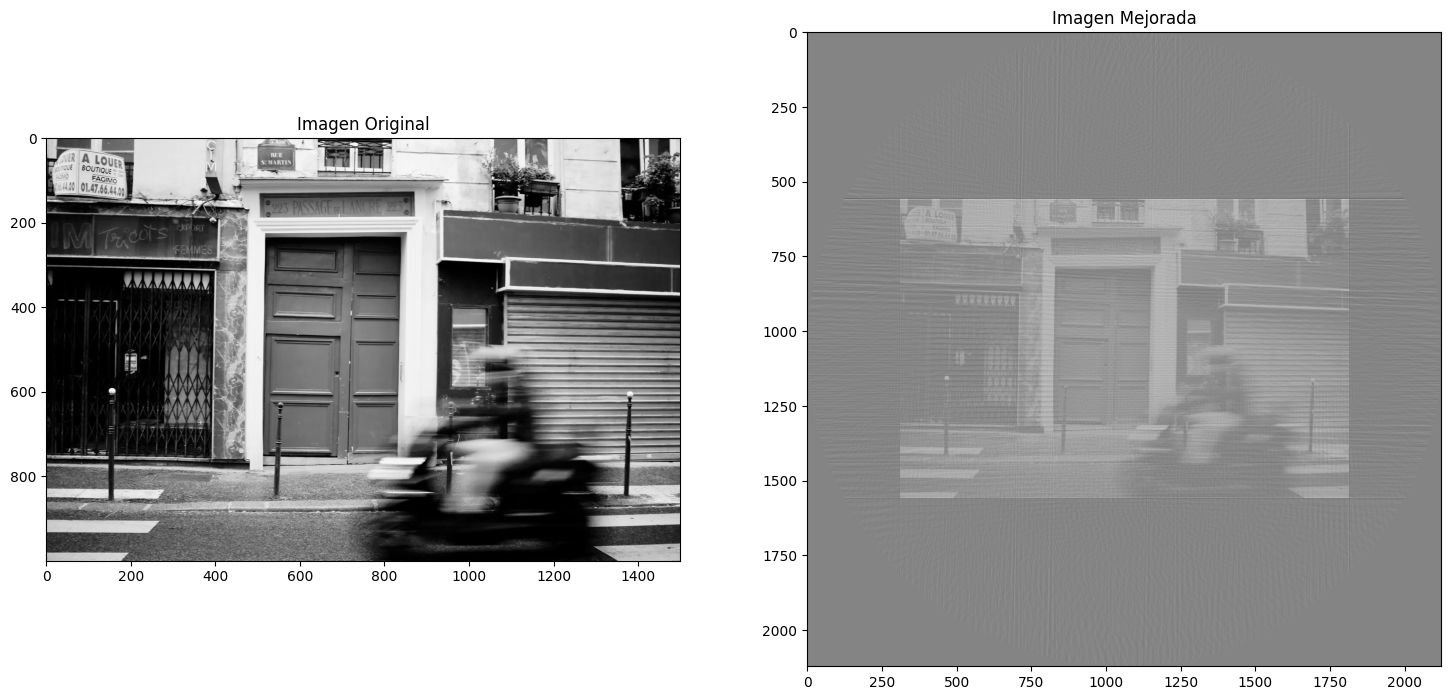

In [9]:
# Visualizar la imagen original y la imagen mejorada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
ax1.set_title("Imagen Original")
ax1.imshow(img, cmap=plt.cm.Greys_r)
ax2.set_title("Imagen Mejorada")
ax2.imshow(reconstruction, cmap=plt.cm.Greys_r)
plt.show()

### All the required Methods

### main.py

(1000, 1500)


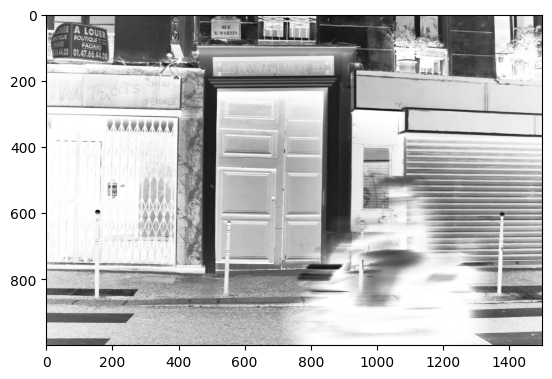

In [10]:
data_path = 'd:/input/'
img_name = 'OOoo.JPG'
img_name='blurred1 - copia.png'
image = invert(io.imread((data_path + img_name),True))
image = img_as_ubyte(rescale(image, scale=1, channel_axis=False))
plt.imshow(image,cmap=plt.cm.Greys_r)
print(image.shape)

In [11]:
def project_1D(im):
  'This method returns the average intensities of all the columns of any 2d image (im)'
  p = np.sum(im,axis=0)
  n = im.shape[0]
  p = p/n
  return p

def get_sinogram(IM,n_theta=90,delta_r=1):
  '''This method returns the required sinogram from any 2d image 
  with user-defined coarseness of distance co-ordinate (delta_r) and 
  the total number of angles (n_theta) to consider for profile capture
  from 0 to 180 degrees.'''

  theta = np.linspace(0.,180.,n_theta)
  n_r = ceil(IM.shape[1]/delta_r)
  sinogram = np.zeros((n_theta,n_r))
  for i in range(n_theta):
    img = rotate(IM, theta[i],preserve_range=True)
    tmp = project_1D(img)
    sinogram[i,:] = tmp[::delta_r]
  print(sinogram.shape)  
  return sinogram

In [12]:
n_theta = 180; delta_r = 1;
sinogram = get_sinogram(image,n_theta,delta_r)

(180, 1500)


In [13]:
def apply_dft(profile):
  '''Returns the 1D direct fourier transform of the input profile
  and also the frequency co-ordinates of the fourier transform'''
  
  N = len(profile)
  k = np.fft.rfftfreq(N)
  out = np.fft.rfft(profile)
  # print(out.shape) para 1024 -> 513
  # print(k)
  return (out,k)

def apply_filter(fft_profile,k,filter_name = 'ramp',cutoff_factor = 1):
  '''Returns the 1D filtered profile of the input fourier transformed profile
  by applying either ramp or shepp-logan filter on the profile.

  k = frequency coordinates of the input fourier transformed profile
  cutoff_factor = value between 0 to 1.
  
  A cutoff can be applied on the maximum value of the frequency coordinates'''

  k_cutoff = cutoff_factor*abs(np.amax(k))
  k[k>k_cutoff] = 0

  if filter_name =='ramp':
    filtered_profile = np.absolute(k)*fft_profile

  if filter_name =='shepp-logan':
    filtered_profile = (2*k_cutoff)/(np.pi) * np.sin((np.absolute(k)*np.pi)/(2*k_cutoff)) * fft_profile

  if filter_name =='none':
    filtered_profile = fft_profile
    
    
  return filtered_profile

def apply_idft(profile):
  filtered_profile = np.real(np.fft.irfft(profile))
  
  return filtered_profile

def get_filtered_sinogram(sino,filter_name = 'ramp',cutoff_factor = 1):
  '''Returns the final reconstructed image by first applying fourier 
  transform on the input sinogram, filtering it and taking inverse fourier 
  of the sinogram. Then, backprojection is applied on the filtered sinogram
  to obtain the final reconstructed image.'''

  filtered_sino = np.zeros(sino.shape); N = sino.shape[1]
  tmp = np.zeros((1,N))
  if (N%2)==0:  # Quirk of fft method; odd and even profiles gives ifft profile of different lengths
    for i in range(sino.shape[0]):
      tmp, k = apply_dft(sino[i,:])
      tmp = apply_filter(tmp,k,filter_name,cutoff_factor)
      filtered_sino[i,:] = apply_idft(tmp)
  else:
    for i in range(sino.shape[0]):
      tmp, k = apply_dft(sino[i,:])
      tmp = apply_filter(tmp,k,filter_name,cutoff_factor)
      filtered_sino[i,:-1] = apply_idft(tmp)

  return filtered_sino

In [14]:
tmp, k = apply_dft(sinogram[1,:])
tmp2=apply_filter(tmp,k,'ramp',1)
print(k)

[0.         0.00066667 0.00133333 0.002      0.00266667 0.00333333
 0.004      0.00466667 0.00533333 0.006      0.00666667 0.00733333
 0.008      0.00866667 0.00933333 0.01       0.01066667 0.01133333
 0.012      0.01266667 0.01333333 0.014      0.01466667 0.01533333
 0.016      0.01666667 0.01733333 0.018      0.01866667 0.01933333
 0.02       0.02066667 0.02133333 0.022      0.02266667 0.02333333
 0.024      0.02466667 0.02533333 0.026      0.02666667 0.02733333
 0.028      0.02866667 0.02933333 0.03       0.03066667 0.03133333
 0.032      0.03266667 0.03333333 0.034      0.03466667 0.03533333
 0.036      0.03666667 0.03733333 0.038      0.03866667 0.03933333
 0.04       0.04066667 0.04133333 0.042      0.04266667 0.04333333
 0.044      0.04466667 0.04533333 0.046      0.04666667 0.04733333
 0.048      0.04866667 0.04933333 0.05       0.05066667 0.05133333
 0.052      0.05266667 0.05333333 0.054      0.05466667 0.05533333
 0.056      0.05666667 0.05733333 0.058      0.05866667 0.0593

In [41]:
filter = 'shepp-logan'; cutoff = 0.4
filtered_sinogram = get_filtered_sinogram(sinogram,filter_name = filter,cutoff_factor = cutoff)

In [42]:
def get_backprojection(sino):
  '''This method returns the backprojected image reconstructed 
  from the input sinogram (sino)'''
    
  IM_out = np.zeros((sino.shape[1],sino.shape[1]))
  n_theta = sino.shape[0]
  theta = np.linspace(0.,180.,n_theta)
  
  for i in range(n_theta):
    tmp = np.zeros((sino.shape[1],sino.shape[1])) + sino[i,:]
    IM_out = IM_out + rotate(tmp, -theta[i],preserve_range=True)

  return IM_out

In [43]:
print(filtered_sinogram.shape)

(180, 1500)


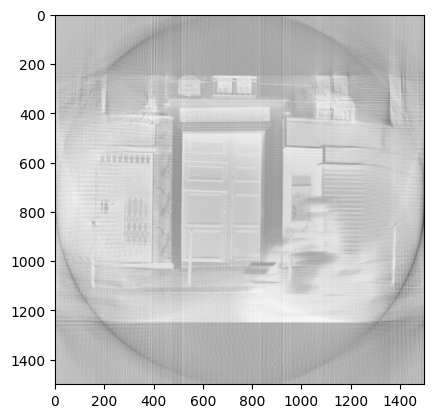

In [44]:
out = get_backprojection(filtered_sinogram)
plt.imshow(out,cmap=plt.cm.Greys_r)